## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import torch_cae_multilevel_V4 as net

## Simulation 

In [2]:
# params
w0 = 0.5
w1 = 4.0
sigma0 = 10.0
sigma1 = 0.25

In [3]:
# define two modes
def phi1(x, y, t):
    return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

def phi2(x, y, t):
    return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

In [4]:
# mesh grids
x = np.linspace(-5, 5, 127)
y = np.linspace(-5, 5, 127)
t = np.linspace(0, 8*np.pi, 500)
xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

In [5]:
# data
Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
print(Phi.shape)

(127, 127, 500)


## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [2]:
# init model & load data
data_path = '../data/toy1'#toy1.npy'
model_path = '../model/toy1/'
result_path = '../result/toy1/'

full_data_path = os.path.join(data_path, 'toy1.npy')
# np.save(full_data_path, scaled_Phi.T)

dataset = net.MultiScaleDynamicsDataSet(full_data_path, n_levels=5)

self.data.shape =  torch.Size([500, 1, 127, 127])


C:\Users\16kat\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
# training
archs = [[1]]#,[1,3,5,7]]
tols = [0.001]#, 0.0005]#, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=3000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=3)

level =  0
archs[i] =  [1]
widen_sizes =  []
deepening
n_levels =  5
using maps
*************************************************
Model @Level 0:
Perform deepening & widening, train each architectures ...
model layers: 
['activation', 'L0_Conv_0', 'L0_deConv_0']
losses printing format: local: mse/max/overall, global: mse/max/overall
epoch [1/3000]
[training set] local: 0.0015/0.0057/0.0036, global: 0.0016/0.0489/0.0252
[validation set] local: 0.0015/0.0064/0.0039, global: 0.0016/0.0535/0.0275
epoch [300/3000]:
[training set] local: 0.0002/0.0045/0.0023, global: 0.0002/0.0475/0.0238
[validation set] local: 0.0002/0.0049/0.0026, global: 0.0002/0.0513/0.0258
early stopping at 300th iteration due to satisfying reconstruction!
-------------------------------------------------


CAE(
  (activation): Sequential()
  (L0_Conv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
  (L0_deConv_0): Conv2dBlock(
    (activation): ReLU()
    (B0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)

In [3]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

model = models['model_L0_0']

model names: model_L{level}_{index}
model_L0_0


In [4]:
model = models['model_L0_0']
i = 0

_, _, data = dataset.obtain_data_at_current_level(level=1)
print()
# print(model.cur_level)
output, _, _, _ = model(data[[0], :, :, :], model.cur_level, verbose = True)

data.size() =  torch.Size([350, 1, 127, 127])
data.size() =  torch.Size([100, 1, 127, 127])
data.size() =  torch.Size([50, 1, 127, 127])
data.size() =  torch.Size([350, 1, 63, 63])
data.size() =  torch.Size([100, 1, 63, 63])
data.size() =  torch.Size([50, 1, 63, 63])
data.size() =  torch.Size([350, 1, 31, 31])
data.size() =  torch.Size([100, 1, 31, 31])
data.size() =  torch.Size([50, 1, 31, 31])

L0_Conv_0
pad
L0_deConv_0
chop
self.n_filter_groups_each_level =  1


In [15]:
def apply_local_op(data, mode='conv', ave=True):
    """
    :param data: data to be processed
    :param device: which device is the data placed in?
    :param mode: string, 'conv' or 'deconv'
    :param ave: if to use local average or sample the center
    :return: processed data
    """
    in_channels, out_channels, n_per_dim, _ = data.size()
    n = min(in_channels, out_channels)
    print("data.size() = ", data.size())
#     in_channels= 1
#     out_channels = 1
#     n = 1
    op = torch.nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=0)
    op.weight.data = torch.zeros(op.weight.data.size())
    print("op.weight.data = ", op.weight.data.size())
    op.bias.data = torch.zeros(op.bias.data.size())
    for i in range(n):
        print("op.weight.data[i, i, 1, 1].size() = ", op.weight.data[i, i, 1, 1].size())
        op.weight.data[i, i, 1, 1] = torch.ones(op.weight.data[i, i, 1, 1].size())

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False

    transformed = np.zeros((in_channels, out_channels, n_per_dim//2, n_per_dim//2))
    print("transformed shape = ", transformed.shape)
#     for i in range(in_channels//)
#     print(op(data).shape)
    return op(data)


#save encoded data

to_encode_path = os.path.join(data_path, 'to_encode.npy')
# to_encode_raw = np.load(to_encode_path)
print("to_encode_raw shape = ", to_encode_raw.shape)
# ghj

n_levels = 5
level = 0
# print(data.shape)
to_encode = torch.tensor(to_encode_raw).T.unsqueeze(1).float()

# to_encode_right_size = torch.zeros((to_encode.size()))

# n_runs, _,_,_ = to_encode.size()

# for r in range(n_runs):
#     print("r = ", r)
# to_encode_this = to_encode[0].unsqueeze(1).float()
for i in range(n_levels - level - 1):
    to_encode = apply_local_op((to_encode), ave=False)
#     to_encode_right_size[r, :,0,:,:] = to_encode_data
    
print("to_encode shape = ", to_encode.shape)


# return train_data
    
# np.save(full_data_path, scaled_Phi.T)

# dataset_encode = net.MultiScaleDynamicsDataSet(to_encode_path, n_levels=5)

level = 0
filter_group_num = 0
model = models['model_L{}_{}'.format(level, filter_group_num)]
# data = dataset_encode.obtain_data_at_current_level_all(level=0)

encoded = model.encode(to_encode, model.cur_level)#, verbose = True)
# decoded = model.decode(encoded, model.cur_level)

print(encoded.shape)
# print(decoded.shape)

#save encoded data 
np.save(os.path.join(data_path, 'data_L{}_{}'.format(level, filter_group_num)), encoded.detach().numpy())

to_encode_raw shape =  (127, 127, 5000)
data.size() =  torch.Size([5000, 1, 127, 127])
op.weight.data =  torch.Size([1, 1, 3, 3])
op.weight.data[i, i, 1, 1].size() =  torch.Size([])
transformed shape =  (5000, 1, 63, 63)
data.size() =  torch.Size([5000, 1, 63, 63])
op.weight.data =  torch.Size([1, 1, 3, 3])
op.weight.data[i, i, 1, 1].size() =  torch.Size([])
transformed shape =  (5000, 1, 31, 31)
data.size() =  torch.Size([5000, 1, 31, 31])
op.weight.data =  torch.Size([1, 1, 3, 3])
op.weight.data[i, i, 1, 1].size() =  torch.Size([])
transformed shape =  (5000, 1, 15, 15)
data.size() =  torch.Size([5000, 1, 15, 15])
op.weight.data =  torch.Size([1, 1, 3, 3])
op.weight.data[i, i, 1, 1].size() =  torch.Size([])
transformed shape =  (5000, 1, 7, 7)
to_encode shape =  torch.Size([5000, 1, 7, 7])
torch.Size([5000, 1, 3, 3])


L0_Conv_0
pad
L0_deConv_0
chop
self.n_filter_groups_each_level =  1


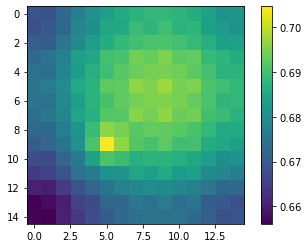

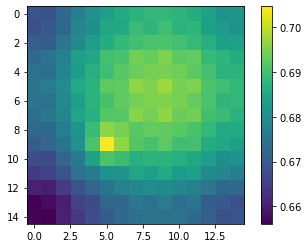

In [19]:
model = models['model_L0_0']
i = 0

_, _, data = dataset.obtain_data_at_current_level(level=1)
# print(model.cur_level)
output, _, _, _ = model(data[[0], :, :, :], model.cur_level, verbose = True)

plt.imshow(output[0,0].detach().numpy())
plt.colorbar()
plt.show()

encoded = model.encode(data[[0], :, :, :], model.cur_level)#, verbose = True)
decoded = model.decode(encoded, model.cur_level)#, verbose = True)

plt.imshow(decoded[0,0].detach().numpy())
plt.colorbar()
plt.show()


torch.Size([1, 1, 7, 7])
torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 7, 7])


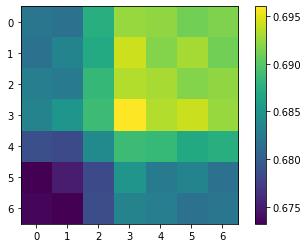

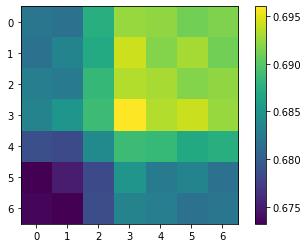

tensor([[[[0.6822, 0.6818, 0.6875, 0.6925, 0.6923, 0.6912, 0.6916],
          [0.6818, 0.6835, 0.6872, 0.6943, 0.6918, 0.6929, 0.6912],
          [0.6830, 0.6826, 0.6884, 0.6934, 0.6930, 0.6918, 0.6922],
          [0.6834, 0.6852, 0.6889, 0.6960, 0.6934, 0.6942, 0.6925],
          [0.6788, 0.6783, 0.6840, 0.6888, 0.6885, 0.6871, 0.6876],
          [0.6732, 0.6749, 0.6783, 0.6851, 0.6826, 0.6835, 0.6817],
          [0.6736, 0.6732, 0.6787, 0.6834, 0.6830, 0.6817, 0.6821]]]],
       grad_fn=<SliceBackward>)
tensor([[[[0.6822, 0.6818, 0.6875, 0.6925, 0.6923, 0.6912, 0.6916],
          [0.6818, 0.6835, 0.6872, 0.6943, 0.6918, 0.6929, 0.6912],
          [0.6830, 0.6826, 0.6884, 0.6934, 0.6930, 0.6918, 0.6922],
          [0.6834, 0.6852, 0.6889, 0.6960, 0.6934, 0.6942, 0.6925],
          [0.6788, 0.6783, 0.6840, 0.6888, 0.6885, 0.6871, 0.6876],
          [0.6732, 0.6749, 0.6783, 0.6851, 0.6826, 0.6835, 0.6817],
          [0.6736, 0.6732, 0.6787, 0.6834, 0.6830, 0.6817, 0.6821]]]],
       gra

In [10]:
i = 0
_, _, data = dataset.obtain_data_at_current_level(level=0)
output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)

# plt.imshow(data[0,0,])


print(output.shape)
encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)
print(encoded.shape)
decoded = model.decode(encoded, model.cur_level)
print(decoded.shape)

plt.imshow(output[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(decoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

print(output)
print(decoded)

In [11]:
def apply_mask(data, mask, mask_type='resolved', width=1):
    """
    :param data: data to be processed
    :param mask: mask, a 2D torch tensor of 0s and 1s
    :param mask_type: resolved map or unresolved map
    :param width: int, specify how large the region is
    :return: a 4D torch tensor represents masked data
    """
    if not isinstance(width, int):
        raise ValueError('width should be a positive integer!')

    # convert to unresolved mask
    if mask_type == 'resolved':
        mask = 1 - mask
        print(mask)
    elif mask_type == 'unresolved':
        mask = mask
    else:
        raise ValueError('mask_type could only be resolved or unresolved!')

    # expansion
    dx = [i for i in range(-width, width+1)]
    dy = [i for i in range(-width, width+1)]
    
    print("dx = ", dx)
    print("dy = ", dy)
    m, n = mask.size()
    print("mask.nonzero() = ", mask.nonzero())
    for c in mask.nonzero():
        x, y = int(c[0]), int(c[1])
        for i in range(2*width+1):
            for j in range(2*width+1):
#                 print(i, ": ", j)
                if 0 <= x + dx[i] < m and 0 <= y + dy[j] < n:
#                     print("x + dx[i] =", x + dx[i])
                    mask[x + dx[i], y + dy[j]] = 1

    # apply
#     print("data shape = ", data.shape)
#     print("mask.unsqueeze(0).unsqueeze(0).float() shape = ", mask.unsqueeze(0).unsqueeze(0).float().shape)
    print("mask.unsqueeze(0).unsqueeze(0).float()= ", mask.unsqueeze(0).unsqueeze(0).float())
    masked_data = data * mask.unsqueeze(0).unsqueeze(0).float()
    return masked_data

# x = torch.tensor([[[[1, 2, 3, 4, 5, 6], [4, 5, 6, 7, 8, 9, ], [7, 8, 9, 10, 11, 12]]]])
# mask = torch.tensor([[0,0,0,0,0,0]]

print(x.shape)
print(mask.size())
masked_x = apply_mask(x, mask)
print(masked_x)

(127,)


NameError: name 'mask' is not defined

## Results

In [ ]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

In [ ]:
print(model.resolved_maps['0']['0'].cpu().detach().numpy().shape)
print(model.resolved_maps['2']['3'].cpu().detach().numpy().shape)

print(model.parameters())
# for param in model.parameters():
#     print(param)

for name, param in model.named_parameters():
    print( name ," : ", param.shape)

In [ ]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

In [ ]:
inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
# model = models['model_L2_3']

_, _, data = dataset.obtain_data_at_current_level(level=4)
i = 0

model = models['model_L0_0']
encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)[0]
print(encoded.shape)
plt.imshow(encoded[0].detach().numpy())
plt.colorbar()
plt.show() 


x = model(data[[i*n_step], :, :, :], model.cur_level)[0]
print(x.shape)
plt.imshow(x[0,0].detach().numpy())
plt.colorbar()
plt.show() 



# model = models['model_L2_1']
# encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)[0]
# print(encoded.shape)
# plt.imshow(encoded[0].detach().numpy())
# plt.colorbar()
# plt.show()

# model = models['model_L2_2']
# encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)[0]
# print(encoded.shape)
# plt.imshow(encoded[0].detach().numpy())


In [ ]:
model = models['model_L0_3']# plt.colorbar()
print(len(model.resolved_maps))
print(model.resolved_maps.keys())

# print(model.resolved_maps['0']['0'])
plt.imshow(model.loss_each_stage['0']['0'].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(model.resolved_maps['0']['0'])
plt.show()
plt.imshow(model.loss_each_stage['0']['1'].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(model.resolved_maps['0']['1'])
plt.show()

plt.imshow(model.loss_each_stage['0']['2'].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(model.resolved_maps['0']['2'])
plt.show()

plt.imshow(model.loss_each_stage['0']['3'].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(model.resolved_maps['0']['3'])
plt.show()


In [ ]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[inds[::n_step]], np.cos(w0*t[inds[::n_step]]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[inds[::n_step]], np.cos(w1*t[inds[::n_step]] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [ ]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

In [ ]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))